In [7]:
import pandas as pd

df = pd.read_csv("../data/kpg_exps.csv")

select_columns = ['time', 'experiment', 'mean ocean surface pH',
                  'benthic DIC_13C (o/oo)',
                  'surface DIC_13C (o/oo)',
                  'temperature (C)',
                  '_benT (C)', '_surT (C)',
                  'global POC flux (mol yr-1)', 'label']
df_subset = df[select_columns]
df_subset['surface - benthic DIC_13C (o/oo)'] = df_subset['surface DIC_13C (o/oo)'].subtract(df_subset['benthic DIC_13C (o/oo)'])

df_subset.rename(columns = {'benthic DIC_13C (o/oo)': 'benthic DIC $\delta^{13}$C (‰)',
                            'surface DIC_13C (o/oo)': 'surface DIC $\delta^{13}$C (‰)',
                            'surface - benthic DIC_13C (o/oo)': r'surface - benthic DIC $\delta^{13}$C (‰)',
                            'global POC flux (mol yr-1)': 'global POC flux (mol yr$^{-1}$)',
                            'temperature (C)': 'temperature (°C)',
                            '_benT (C)': 'benthic ocean temperature (°C)',
                            '_surT (C)': 'surface ocean temperature (°C)',
                            'time': 'Time after the impact (yr)',
                            'label': 'Effect of the impact'
                            },   inplace = True)

df_subset['Time after the impact (yr)'] = df_subset['Time after the impact (yr)'] - 100

## convert to long format
df_subset = pd.melt(df_subset, id_vars=['Time after the impact (yr)', 'experiment','Effect of the impact'], 
                    value_vars=[
                                'temperature (°C)', 
                                'benthic ocean temperature (°C)',
                                'surface ocean temperature (°C)',
                        'benthic DIC $\delta^{13}$C (‰)',
                        'surface DIC $\delta^{13}$C (‰)',
                        r'surface - benthic DIC $\delta^{13}$C (‰)',
                        'mean ocean surface pH',
                        r'global POC flux (mol yr$^{-1}$)'],
                    var_name='variable', value_name='value')

/var/folders/rq/vks10_qx2l9b08d_pygvwfzh0000gn/T/ipykernel_1053/39479274.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['surface - benthic DIC_13C (o/oo)'] = df_subset['surface DIC_13C (o/oo)'].subtract(df_subset['benthic DIC_13C (o/oo)'])
/var/folders/rq/vks10_qx2l9b08d_pygvwfzh0000gn/T/ipykernel_1053/39479274.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.rename(columns = {'benthic DIC_13C (o/oo)': 'benthic DIC $\delta^{13}$C (‰)',
/var/folders/rq/vks10_qx2l9b08d_pygvwfzh0000gn/T/ipykernel_1053/39479274.py:25: SettingWithCopyWarn

<Figure size 640x480 with 0 Axes>

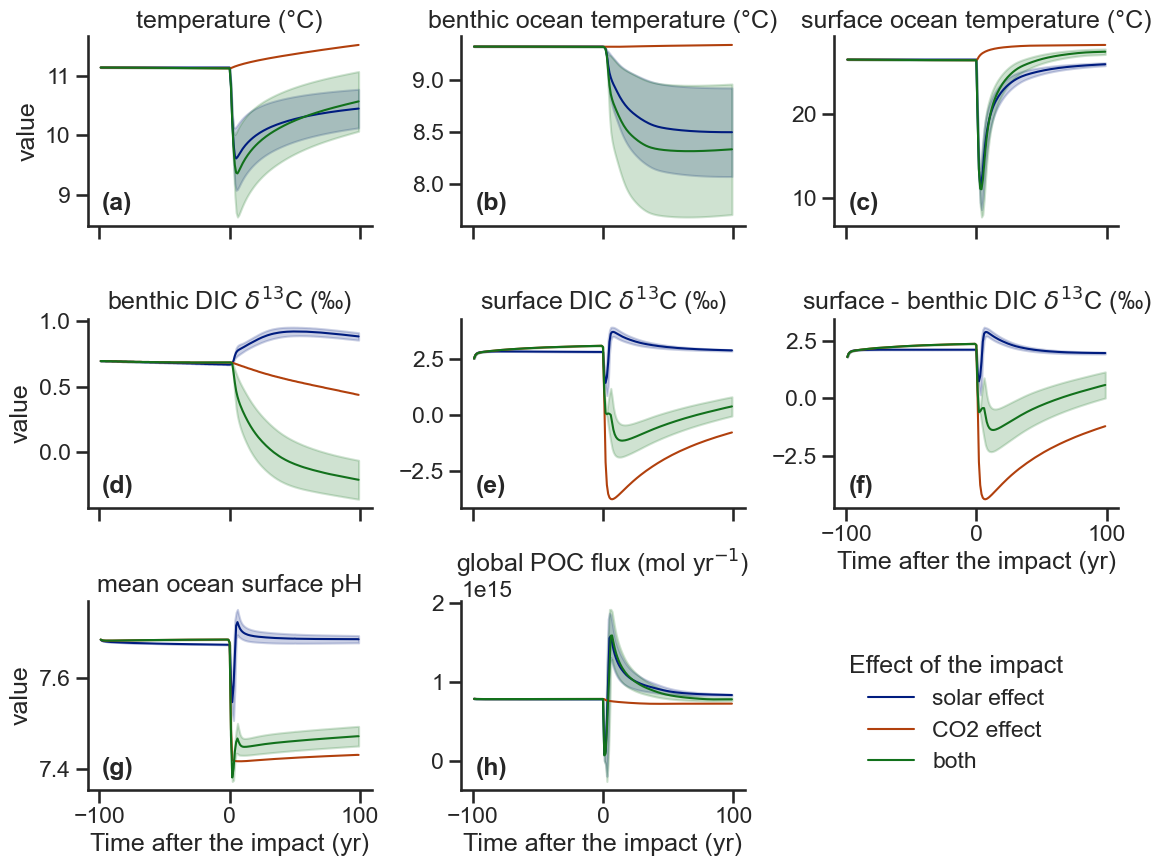

In [8]:
import seaborn as sns

## create figure
sns.set_style("ticks")
sns.set_context("talk")
sns.despine()

## facet grid
g = sns.FacetGrid(df_subset, col="variable", hue="Effect of the impact",
                    col_wrap=3, height=3, aspect=1.3,
                    palette="dark",
                  sharey=False)

## plot line plot with errorbar
g.map(sns.lineplot, "Time after the impact (yr)", "value", errorbar="sd", linewidth=1.5)
g.set_titles("{col_name}")

g.add_legend(loc='lower right', bbox_to_anchor=(0.8, 0.1))

## annotate each subplot using alphabetical letters
import string
import matplotlib.pyplot as plt

for i,ax in enumerate(g.axes.ravel()):
    letter = string.ascii_lowercase[i]
    # Get the corresponding letter from the alphabet
    ax.annotate(f"({letter})", xy=(0.05, 0.08),
                weight='bold',
                xycoords="axes fraction")

g.savefig("../output/fig3.png", dpi=300)